In [32]:
%env CUDA_VISIBLE_DEVICES=4
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=4
env: OMP_NUM_THREADS=16


In [33]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"

In [34]:
from transformers import AutoModelForCausalLM

model_pt = AutoModelForCausalLM.from_pretrained(
    '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/',
    trust_remote_code=True, torch_dtype="auto", device_map='meta',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [5]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [6]:
data_df = get_df_from_wandb('rock-and-roll/GALQIWI_EDENN_GPTQ')

data_df = data_df.rename(columns={
    'wikitext2_PPL': 'wikitext2',
})

data_df = data_df[data_df['model'] == MODEL]

data_df = data_df[['layer_idx', 'edenn_d', 'edenn_n', 'wikitext2']]

data_df = data_df.dropna().copy()

100%|███████████████████████████████████████| 2869/2869 [00:43<00:00, 65.61it/s]


In [7]:
layer_names = []

for layer_idx in range(32):
    layer_names.append(f'model.layers.{layer_idx}.self_attn.q_proj')
    layer_names.append(f'model.layers.{layer_idx}.self_attn.k_proj')
    layer_names.append(f'model.layers.{layer_idx}.self_attn.v_proj')
    layer_names.append(f'model.layers.{layer_idx}.self_attn.o_proj')
    layer_names.append(f'model.layers.{layer_idx}.mlp.gate_proj')
    layer_names.append(f'model.layers.{layer_idx}.mlp.up_proj')
    layer_names.append(f'model.layers.{layer_idx}.mlp.down_proj')

In [8]:
data_df['layer'] = data_df['layer_idx'].apply(lambda idx: layer_names[idx])

In [9]:
layers = sorted(set(data_df['layer']))
len(layers)

224

In [36]:
import requests
from ast import literal_eval
import pandas as pd

grids = literal_eval(requests.get(
    'https://gist.githubusercontent.com/BlackSamorez/c74f24a648eb8bbfbbbf83f3145ba3c7/raw/ddc3280a4861938e2e2034c29d6802817e26e799/gistfile1.txt'
).text)

grids.append({
    'edenn_d': -1,
    'edenn_n': -1,
    'bits': 16,
    'mse': 0.0,
})

grids = pd.DataFrame(grids)
grids['name'] = grids.apply(
    lambda row: 'edenn_d=' + str(row['edenn_d']) + ';edenn_n=' + str(row['edenn_n']),
    axis=1,
)
grids = grids[['bits', 'mse', 'name', 'edenn_d', 'edenn_n']]
print(len(grids))
grids.sample(3)

76


,bits,mse,name,edenn_d,edenn_n
58,0.333333,0.760724,edenn_d=6.0;edenn_n=4.0,6,4
41,0.800000,0.427703,edenn_d=5.0;edenn_n=16.0,5,16
54,0.166667,0.892925,edenn_d=6.0;edenn_n=2.0,6,2


In [37]:
def get_mse(grid_tuple):
    edenn_d, edenn_n = grid_tuple
    name = f'edenn_d={edenn_d}.0;edenn_n={edenn_n}.0'
    output = grids[grids['name'] == name]['mse'].values[0]
    return output

In [38]:
data_df['mse'] = data_df[['edenn_d', 'edenn_n']].apply(
    lambda row: get_mse(tuple(row.values)),
    axis=1,
)

In [39]:
BASE_PPL = 5.606692790985107

In [40]:
from sklearn.linear_model import LinearRegression

scale_by_layer = {}
intercept_by_layer = {}

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    to_fit = to_fit[to_fit['mse'] < 0.04]
    # to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    # to_fit = to_fit[to_fit['wikitext2'] < 5.640]

    slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
    
    scale_by_layer[layer] = slope.item()
    intercept_by_layer[layer] = BASE_PPL

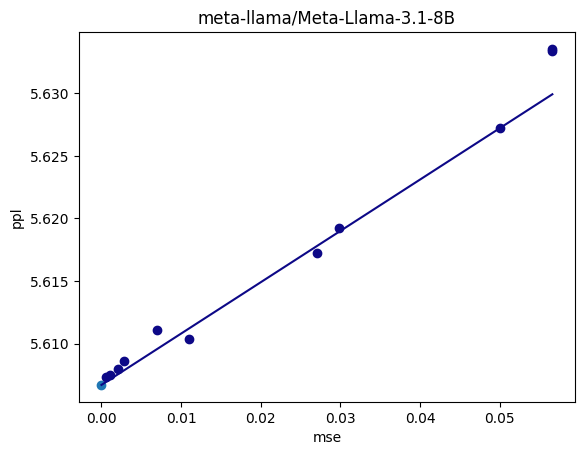

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

plt.scatter([0.0], [5.606692790985107])

for layer_idx, layer in enumerate({'model.layers.0.mlp.down_proj'}):
# for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer'] == layer]
    to_plot = to_plot[to_plot['mse'] < 0.07]
    # to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / len(layers)))

    grid = np.linspace(0, to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercept_by_layer[layer] + grid * scale_by_layer[layer], color=cmap(layer_idx / len(layers)))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [42]:
pd.DataFrame(scale_by_layer.items(), columns=['layer', 'scale']).sort_values('scale')

,layer,scale
3,model.layers.0.self_attn.k_proj,0.010686
5,model.layers.0.self_attn.q_proj,0.011769
10,model.layers.1.self_attn.k_proj,0.012210
12,model.layers.1.self_attn.q_proj,0.015895
124,model.layers.24.self_attn.q_proj,0.017539
...,...,...
91,model.layers.20.mlp.down_proj,0.358584
0,model.layers.0.mlp.down_proj,0.410446
176,model.layers.31.mlp.gate_proj,0.458512
175,model.layers.31.mlp.down_proj,0.471280


In [43]:
from ortools.linear_solver import pywraplp

def find_grids_with_budget(
    slopes,    # linear coefficients for [layerwise mse -> metric]
    weights,   # linear coefficients for [layer bitwidth -> total bitwidth] (1 / num_blocks for blockwise)
    budget,    # upper bound on total bitwidth
    grid_bits, # available grid bitwidths
    grid_mses  # available grid mses
) -> tuple[float, list]:
    num_layers = len(slopes)
    num_grids = len(grid_bits)
    assert len(grid_mses) == num_grids
    
    solver = pywraplp.Solver.CreateSolver("CP-SAT")

    x = {(j, i) : solver.BoolVar("name") for i in range(num_grids) for j in range(num_layers)}
    
    for j in range(num_layers) : solver.Add(sum(x[(j, i)] for i in range(num_grids)) == 1)
    solver.Add(sum(x[(j, i)] * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids)) <= budget)
    solver.Minimize(sum(x[(j, i)] * slopes[j] * grid_mses[i] for j in range(num_layers) for i in range(num_grids)))

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        avg_bits = sum(x[(j, i)].solution_value() * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids))
        solution = np.asarray([[x[(j, i)].solution_value() for i in range(num_grids)] for j in range(num_layers)])
        indices = np.argwhere(solution == 1.0)
        assert len(indices) == num_layers
        return avg_bits, indices[:,1]
    else:
        raise Exception("Didn't solve")

In [58]:
ok_grids = grids[grids['bits'] > 1.5]
# ok_grids = grids[grids['edenn_n'].apply(lambda n: n in (2, 4, 8, 16, 256))]

In [59]:
ok_grids

,bits,mse,name,edenn_d,edenn_n
0,4.000000,0.009693,edenn_d=1.0;edenn_n=16.0,1,16
2,5.000000,0.002822,edenn_d=1.0;edenn_n=32.0,1,32
3,2.000000,0.116292,edenn_d=1.0;edenn_n=4.0,1,4
4,6.000000,0.001085,edenn_d=1.0;edenn_n=64.0,1,64
5,3.000000,0.034860,edenn_d=1.0;edenn_n=8.0,1,8
8,5.000000,0.002038,edenn_d=2.0;edenn_n=1024.0,2,1024
9,3.500000,0.015299,edenn_d=2.0;edenn_n=128.0,2,128
10,2.000000,0.108354,edenn_d=2.0;edenn_n=16.0,2,16
12,4.000000,0.007742,edenn_d=2.0;edenn_n=256.0,2,256
13,2.500000,0.056591,edenn_d=2.0;edenn_n=32.0,2,32


In [60]:
layers = sorted(layers)

scales = [scale_by_layer[layer] for layer in layers]
numels = [get_numel(layer) for layer in layers]
grid_names=ok_grids['name'].values
grid_bits=ok_grids['bits'].values
grid_mses=ok_grids['mse'].values

solution_size, solution_idxs = find_grids_with_budget(
    scales,
    numels,
    budget=sum(numels) * 3,
    grid_bits=ok_grids['bits'].values,
    grid_mses=ok_grids['mse'].values,
)

print(f'{solution_size / sum(numels)} bits')

2.999949919871794 bits


In [61]:
solution_names = [grid_names[idx] for idx in solution_idxs]
solution_mses = [grid_mses[idx] for idx in solution_idxs]

<BarContainer object of 224 artists>

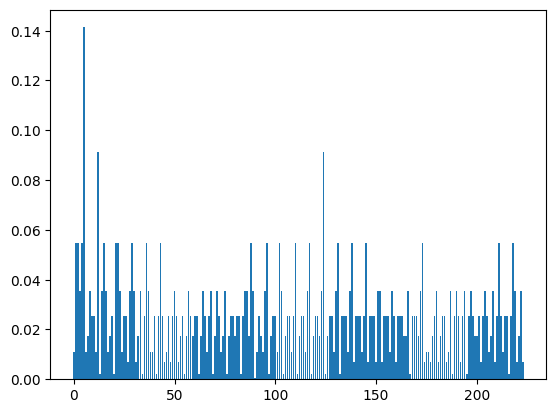

In [62]:
plt.bar(range(len(solution_mses)), solution_mses)

In [63]:
np.mean(solution_mses), np.min(solution_mses), np.max(solution_mses)

(0.024670672283848814, 0.0005824833642691374, 0.1413695514202118)

In [64]:
BASE_PPL + sum([scale * mse for scale, mse in zip(scales, solution_mses)])

6.242172178307512

In [65]:
optimal_by_layer = dict(zip(layers, solution_names))

In [66]:
def to_list(name):
    return [round(float(x.split('=')[-1])) for x in name.split(';')]

print(*grids[grids['bits'] > 2.0].sort_values('mse')['name'].values, sep='\n')

edenn_d=-1.0;edenn_n=-1.0
edenn_d=2.0;edenn_n=4096.0
edenn_d=1.0;edenn_n=64.0
edenn_d=2.0;edenn_n=1024.0
edenn_d=1.0;edenn_n=32.0
edenn_d=3.0;edenn_n=4096.0
edenn_d=2.0;edenn_n=256.0
edenn_d=1.0;edenn_n=16.0
edenn_d=3.0;edenn_n=2048.0
edenn_d=2.0;edenn_n=128.0
edenn_d=3.0;edenn_n=1024.0
edenn_d=4.0;edenn_n=4096.0
edenn_d=3.0;edenn_n=512.0
edenn_d=2.0;edenn_n=64.0
edenn_d=1.0;edenn_n=8.0
edenn_d=4.0;edenn_n=2048.0
edenn_d=3.0;edenn_n=256.0
edenn_d=4.0;edenn_n=1024.0
edenn_d=5.0;edenn_n=4096.0
edenn_d=2.0;edenn_n=32.0
edenn_d=4.0;edenn_n=512.0
edenn_d=5.0;edenn_n=2048.0


In [67]:
set(data_df[['edenn_d', 'edenn_n']].apply(
    lambda row: tuple(row.values),
    axis=1,
))

{(1, 32),
 (1, 64),
 (2, 32),
 (2, 64),
 (2, 1024),
 (2, 4096),
 (3, 512),
 (3, 2048),
 (3, 4096),
 (4, 1024),
 (5, 2048),
 (6, 4096)}

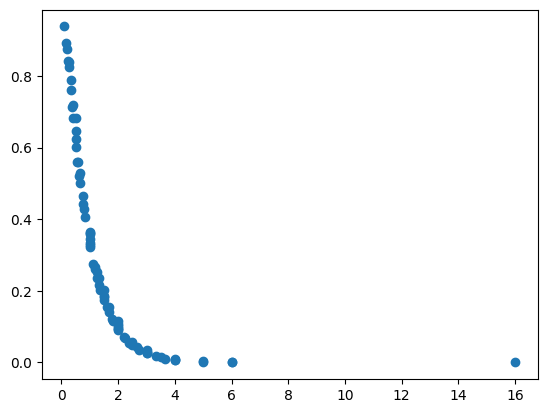

In [68]:
plt.scatter(grids['bits'], grids['mse'])

In [69]:
layer_idx = 0

def to_list(name):
    return [round(float(x.split('=')[-1])) for x in name.split(';')]

output = []

for layer_idx in range(32):
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.q_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.k_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.v_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.o_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.gate_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.up_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.down_proj']))

print(output)

[[6, 1024], [4, 2048], [3, 2048], [5, 4096], [5, 4096], [5, 4096], [3, 2048], [6, 4096], [4, 4096], [2, 1024], [3, 2048], [4, 2048], [4, 4096], [3, 1024], [4, 2048], [3, 1024], [2, 4096], [5, 4096], [4, 2048], [4, 2048], [4, 4096], [4, 2048], [3, 1024], [2, 1024], [3, 1024], [4, 4096], [4, 4096], [4, 4096], [4, 2048], [3, 4096], [2, 1024], [3, 2048], [4, 4096], [4, 4096], [3, 1024], [4, 2048], [3, 4096], [2, 1024], [4, 4096], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [3, 1024], [3, 4096], [3, 1024], [4, 2048], [4, 4096], [4, 4096], [4, 2048], [3, 2048], [3, 4096], [3, 1024], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [3, 2048], [2, 1024], [4, 4096], [5, 4096], [4, 4096], [4, 4096], [4, 2048], [3, 4096], [3, 4096], [3, 1024], [5, 4096], [4, 2048], [4, 4096], [4, 4096], [3, 2048], [2, 1024], [3, 1024], [5, 4096], [4, 2048], [4, 2048], [4, 4096], [3, 2048], [3, 4096], [4, 4096], [5, 4096], [4, 2048], [5, 4096], [4, 2048], [3, 4096], [2, 1024], [3, 1024], [5, 4096], [4, 2048], [4, 2048]

In [4]:
sorted(set(tuple(x) for x in [[6, 1024], [4, 2048], [3, 2048], [5, 4096], [5, 4096], [5, 4096], [3, 2048], [6, 4096], [4, 4096], [2, 1024], [3, 2048], [4, 2048], [4, 4096], [3, 1024], [4, 2048], [3, 1024], [2, 4096], [5, 4096], [4, 2048], [4, 2048], [4, 4096], [4, 2048], [3, 1024], [2, 1024], [3, 1024], [4, 4096], [4, 4096], [4, 4096], [4, 2048], [3, 4096], [2, 1024], [3, 2048], [4, 4096], [4, 4096], [3, 1024], [4, 2048], [3, 4096], [2, 1024], [4, 4096], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [3, 1024], [3, 4096], [3, 1024], [4, 2048], [4, 4096], [4, 4096], [4, 2048], [3, 2048], [3, 4096], [3, 1024], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [3, 2048], [2, 1024], [4, 4096], [5, 4096], [4, 4096], [4, 4096], [4, 2048], [3, 4096], [3, 4096], [3, 1024], [5, 4096], [4, 2048], [4, 4096], [4, 4096], [3, 2048], [2, 1024], [3, 1024], [5, 4096], [4, 2048], [4, 2048], [4, 4096], [3, 2048], [3, 4096], [4, 4096], [5, 4096], [4, 2048], [5, 4096], [4, 2048], [3, 4096], [2, 1024], [3, 1024], [5, 4096], [4, 2048], [4, 2048], [4, 4096], [3, 2048], [2, 1024], [3, 2048], [5, 4096], [4, 2048], [4, 4096], [4, 4096], [3, 4096], [3, 4096], [3, 2048], [5, 4096], [4, 4096], [4, 4096], [4, 4096], [3, 4096], [2, 1024], [3, 1024], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [3, 1024], [2, 1024], [4, 4096], [4, 2048], [4, 4096], [3, 1024], [4, 2048], [3, 2048], [2, 1024], [4, 4096], [4, 2048], [4, 4096], [3, 1024], [4, 2048], [3, 2048], [2, 1024], [3, 1024], [4, 2048], [4, 4096], [3, 1024], [4, 4096], [3, 1024], [2, 1024], [4, 4096], [4, 4096], [4, 4096], [3, 1024], [5, 4096], [3, 2048], [2, 1024], [4, 2048], [4, 4096], [3, 1024], [3, 2048], [4, 2048], [3, 2048], [2, 1024], [5, 4096], [4, 4096], [4, 4096], [3, 1024], [5, 4096], [3, 2048], [2, 1024], [4, 4096], [4, 4096], [4, 4096], [3, 1024], [5, 4096], [3, 2048], [2, 1024], [4, 2048], [4, 4096], [4, 4096], [3, 1024], [6, 4096], [3, 1024], [2, 1024], [4, 2048], [4, 4096], [4, 4096], [3, 1024], [5, 4096], [3, 2048], [2, 1024], [4, 2048], [4, 4096], [4, 4096], [3, 1024], [5, 4096], [3, 2048], [3, 4096], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [5, 4096], [3, 2048], [3, 4096], [4, 4096], [4, 4096], [4, 4096], [4, 4096], [4, 2048], [3, 4096], [3, 4096], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [4, 4096], [3, 2048], [3, 4096], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [5, 4096], [3, 1024], [3, 4096], [4, 2048], [4, 4096], [4, 4096], [4, 4096], [4, 2048], [3, 1024], [3, 4096], [4, 4096], [3, 2048], [3, 4096], [3, 2048]]))

[(2, 1024),
 (2, 4096),
 (3, 1024),
 (3, 2048),
 (3, 4096),
 (4, 2048),
 (4, 4096),
 (5, 4096),
 (6, 1024),
 (6, 4096)]

In [30]:
!git add . && git commit -m 'linear-layer-compression' && git push

[galqiwi d28b543] linear-layer-compression
 2 files changed, 620 insertions(+), 1356 deletions(-)
 rewrite Vladimir/2024-09-06/gptq-linear-layer-compression/values.ipynb (86%)
Counting objects: 8, done.
Delta compression using up to 255 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 1.91 KiB | 976.00 KiB/s, done.
Total 8 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To github.com:galqiwi/linear-layer-compression.git
   68a65fe..d28b543  galqiwi -> galqiwi
